In [17]:
#Assignment 8
#Extended Kalman filter for navigation and tracking
#Team 12
#Yaroslav Savotin, Elizaveta Pestova, Selamawit Asfaw
#Skoltech, 2023

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# fuction for generating trajectory
def generate_Xt(x0, sigma_a, Fi, G, N):  
    ax = np.random.normal(0, np.sqrt(sigma_a), size = (1, 1, N))
    ay = np.random.normal(0, np.sqrt(sigma_a), size =(1, 1, N))
    
    A = np.zeros((2, 1, N))
    for i in range(N):
        A[0,0,i] = ax[0][0][i]
        A[1,0,i] = ay[0][0][i]
    
    Xt = np.zeros((4, 1, N))
    Xt[:, :, 0] = x0
    for i in range(1, N):
        Xt[:, :, i] = np.dot(Fi,Xt[:, :, i-1]) + np.dot(G,A[:, :, i-1])
    return Xt

# Generate Distance and Beta 
def generate_DB(Xt,sigmaD, sigmaB, N):
    D = np.zeros((1, 1, N))
    Beta = np.zeros((1, 1, N))
    Dm = np.zeros((1, 1, N))
    Betam = np.zeros((1, 1, N))
      
    nuD = np.random.normal(0, np.sqrt(sigmaD), size =(1, 1, N))
    nuB = np.random.normal(0, np.sqrt(sigmaB), size =(1, 1, N))
    
    for i in range(N):
        D[:, :, i] = np.sqrt(Xt[0, 0, i]**2 + Xt[2, 0, i]**2)
        Beta[:, :, i] = np.arctan(Xt[0, 0, i] / Xt[2, 0, i])
        Dm[:, :, i] = D[:, :, i] + nuD[:, :, i]
        Betam[:, :, i] = Beta[:, :, i] + nuB[:, :, i]
    return D, Beta, Dm, Betam

In [12]:

# Developing Kalman filter algorithm to estimate state vector (extrapolation and filtration). Using extrapolated and filtered
# estimates at every extrapolation and filtration step we calculate range(D) and azimuth. 

def Extended_kalmanFilter(Fi, Q, R, X0, P0, Dm, Betam, N):
    
    Zm = np.zeros((2, 1, N)) #measurement in !!!polar coordinates!!!
    for i in range(N):
        Zm[0, :, i] = Dm[:, :, i]
        Zm[1, :, i] = Betam[:, :, i]
    
    Xf = np.zeros((4, 1, N)) #Filtration of state vector
    Pf = np.zeros((4, 4, N)) #Filtration error covariance matrix
    Xp = np.zeros((4, 1, N)) #Prediction of state vector
    Pp = np.zeros((4, 4, N)) #Prediction error covariance matrix
    
    Df = np.zeros((1, 1, N))
    Betaf = np.zeros((1, 1, N))
    Dp = np.zeros((1, 1, N))
    Betap = np.zeros((1, 1, N))
    
    #coordinates in Cartesian coordinate system
    Xm = np.zeros((1, 1, N)) 
    Ym = np.zeros((1, 1, N))
    
    
    K = np.zeros((4, 2, N)) #Filter gain
    dh = np.zeros((2, 4, N)) #Derivative
    h = np.zeros((2, 1, N)) #Nonlinear function
    
    #Initial conditions
    Df[:, :, 0] = Dm[:, :, 0]
    Betaf[:, :, 0] = Betam[:, :, 0]
    Dp[:, :, 0] = Dm[:, :, 0]
    Betap[:, :, 0] = Betam[:, :, 0]
    
    Pf[:, :, 0] = P0
    Xf[:, :, 0] = X0
    
    #Transformation from polar to Cartesian coordinate system
    Xm[:, :, 0] = Dm[:, :, 0][0][0] * np.sin(Betam[:, :, 0])[0][0]
    Ym[:, :, 0] = Dm[:, :, 0][0][0] * np.cos(Betam[:, :, 0])[0][0]
    
    ### #------------№8------------
    #linearizing measurement equation
    
    #Derivative
    dh[:, :, 0] = np.array([[(Xm[:, :, 0]/np.sqrt(Xm[:, :, 0]**2+Ym[:, :, 0]**2))[0][0], 0, (Ym[:, :, 0]/np.sqrt(Xm[:, :, 0]**2+Ym[:, :, 0]**2))[0][0], 0],
                            [(Ym[:, :, 0]/(Xm[:, :, 0]**2+Ym[:, :, 0]**2))[0][0], 0, (-Xm[:, :, 0]/(Xm[:, :, 0]**2+Ym[:, :, 0]**2))[0][0], 0]])
    for i in range(N-1):
        #Prediction (extrapolation)
        Xp[:, :, i+1] = np.dot(Fi, Xf[:, :, i])
        
            #range D, azimuth Beta at every extrapolation step 
        Dp[:, :, i+1] = np.sqrt((Xp[0, :, i+1]**2) + (Xp[2, :, i+1]**2))
        Betap[:, :, i+1] = np.arctan(Xp[0, :, i+1] / Xp[2, :, i+1])
        
            #Transformation from polar to Cartesian coordinate system
        Xm[:, :, i+1] = Dp[:, :, i+1][0][0] * np.sin(Betap[:, :, i+1])[0][0]
        Ym[:, :, i+1] = Dp[:, :, i+1][0][0] * np.cos(Betap[:, :, i+1])[0][0]
        
            #Derivative
        dh[:, :, i+1] = np.array([[(Xm[:, :, i+1]/np.sqrt(Xm[:, :, i+1]**2+Ym[:, :, i+1]**2))[0][0], 0, (Ym[:, :, i+1]/np.sqrt(Xm[:, :, i+1]**2+Ym[:, :, i+1]**2))[0][0], 0],
                            [(Ym[:, :, i+1]/(Xm[:, :, i+1]**2+Ym[:, :, i+1]**2))[0][0], 0, (-Xm[:, :, i+1]/(Xm[:, :, i+1]**2+Ym[:, :, i+1]**2))[0][0], 0]])
        
        Pp[:, :, i+1] = np.dot(np.dot(Fi, Pf[:, :, i]), np.transpose(Fi)) + Q
        
        h[0, :, i+1] = Dp[:, :, i+1]
        h[1, :, i+1] = Betap[:, :, i+1]
        
        #Filtration
            #Filter gain
        K[:, :, i+1] = np.dot(np.dot(Pp[:, :, i+1], np.transpose(dh[:, :, i+1])), np.linalg.inv(np.dot(np.dot(dh[:, :, i+1], Pp[:, :, i+1]), np.transpose(dh[:, :, i+1])) + R))
            #Improved estimate by incorporating a new measurement
        Xf[:, :, i+1] = Xp[:, :, i+1] + np.dot(K[:, :, i+1], (Zm[:, :, i+1] - h[:, :, i+1]))
            #range D, azimuth Beta at every filtration step 
        Df[:, :, i+1] = np.sqrt((Xf[0, :, i+1]**2) + (Xf[2, :, i+1]**2))
        Betaf[:, :, i+1] = np.arctan(Xf[0, :, i+1] / Xf[2, :, i+1])
        
            #Filtration error covariance matri
        Pf[:, :, i+1] = np.dot((np.eye(4) - np.dot(K[:, :, i+1], dh[:, :, i+1])), Pp[:, :, i+1])
    
    return Xf, Dp, Betap, Df, Betaf

In [13]:
def calculate_MSE(N, M, x0, sigma_a, sigmaD, sigmaB, Fi, G, Q, R, X0, P0):
    Error_run = np.zeros((2, M, N))
    final_Error = np.zeros((1, 2, N))
    Error_run1 = np.zeros((2, M, N))
    final_Error1 = np.zeros((1, 2, N))
    Pot = np.zeros((2, 1, N))
    Pof = np.zeros((2, 1, N))
    Pop = np.zeros((2, 1, N))
    
    for i in range(M):
        Xt = generate_Xt(x0, sigma_a, Fi, G, N)
        D, Beta, Dm, Betam = generate_DB(Xt,sigmaD, sigmaB, N)
        Xf, Dp, Betap, Df, Betaf = Extended_kalmanFilter(Fi, Q, R, X0, P0, Dm, Betam, N)
        
        for i in range(N):
            Pot[0,0,i] = D[0][0][i]
            Pot[1,0,i] = Beta[0][0][i]
            
            Pof[0,0,i] = Df[0][0][i]
            Pof[1,0,i] = Betaf[0][0][i]
            
            Pop[0,0,i] = Dp[0][0][i]
            Pop[1,0,i] = Betap[0][0][i]
        
        for j in range(N):
            Error_run[:, i, j] = ((Pot[:, :, j] - Pof[:, :, j]) ** 2).T
            Error_run1[:, i, j] = ((Pot[:, :, j] - Pop[:, :, j]) ** 2).T
    
    for i in range(N):
        for k in range(M):
            final_Error[:, :, i] += Error_run[:, k, i]
            final_Error1[:, :, i] += Error_run1[:, k, i]
        
        final_Error[:, :, i] = np.sqrt(final_Error[:, :, i] / (M - 1))
        final_Error1[:, :, i] = np.sqrt(final_Error1[:, :, i] / (M - 1))
             
    return final_Error, final_Error1

In [14]:
#------------№1------------
# Initial conditions
N = 500 # Size of trajectory
step = np.arange(N)

T = 1 # interval between measurements

x0 = np.array([[1000], [10], [1000], [10]]) #Initial

sigma_a = 0.3**2  #Variance of noise

sigmaD = 50**2
sigmaB = 0.004**2

#------------№5------------
# Transition Matrix
Fi = np.array([[1, T, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, T],
               [0, 0, 0, 1]])
#--------------------------

# Input matrix
G = np.array([[(T**2)/2, 0],
              [T, 0],
              [0 ,(T**2)/2],
              [0, T]])

#Generate a true trajectory
Xt = generate_Xt(x0, sigma_a, Fi, G, N)
#------------№2,3------------
#Generate also true values of range D and azimuth Beta
#Generate measurements Dm, Betam
D, Beta, Dm, Betam = generate_DB(Xt,sigmaD, sigmaB, N)

#------------№4------------
#Initial conditions for Extended Kalman filter algorithm
#Initial filtered estimate of state vector X0,0
X0 = np.array([[Dm[0, 0, 0] * np.sin(Betam[0, 0, 0])],
               [0],
               [Dm[0, 0, 0] * np.cos(Betam[0, 0, 0])],
               [0]])

#Initial filtration error covariance matrix P0,0
P0 = np.array([[10**10, 0, 0, 0],
               [0, 10**10, 0, 0],
               [0, 0, 10**10, 0],
               [0, 0, 0, 10**10]])

#------------№6------------
#State noise covariance matrix
Q = np.dot(G,G.T)*sigma_a

#------------№7------------
#Measurement noise covariance
R = np.array([[sigmaD,0],
              [0,sigmaB]])

M = 500

#MSE1, MSE2 = calculate_MSE(N, M, x0, Va, Vpb, Vpd, Fi, G, Q, R, X0, P0)
#MSE3, MSE4 = calculate_MSE1(N, M, x0, Va, Vpb, Vpd, Fi, G, Q, R, X0, P0)

In [15]:
Xf, Dp, Betap, Df, Betaf = Extended_kalmanFilter(Fi, Q, R, X0, P0, Dm, Betam, N)

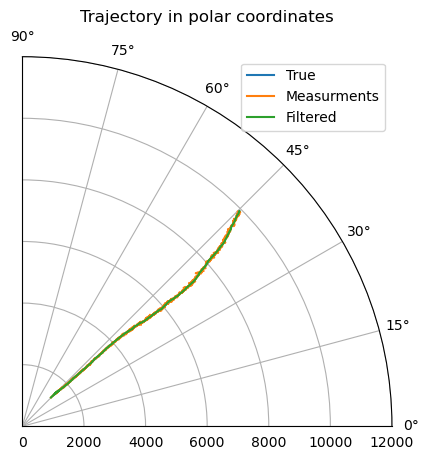

In [16]:
ax = plt.subplot(111, projection='polar')
ax.plot(Beta[0][0], D[0][0], label='True')
ax.plot(Betam[0][0], Dm[0][0], label='Measurments')
ax.plot(Betap[0][0], Dp[0][0], label='Filtered')
ax.set_title('Trajectory in polar coordinates')
ax.set_xlim(0,np.radians(90))
ax.set_ylim(0,12000)
ax.legend()

plt.show()

Conclusion: for the true, measurement and filtered Beta the filter is working really good we can see that the true trajectory and filtered trajectory are match.

In [9]:
#------------№10------------
#mean-squared error
MSE1, MSE2 = calculate_MSE(N, M, x0, sigma_a, sigmaD, sigmaB, Fi, G, Q, R, X0, P0)

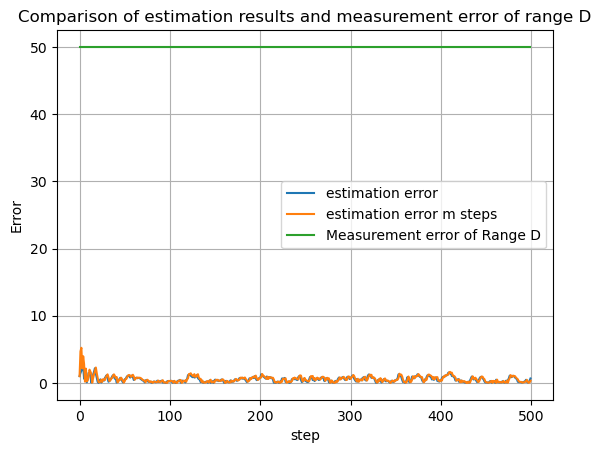

In [18]:
# Plot
#estimation results with measurement errors of Range D
sigmaD_v = np.sqrt(sigmaD)*np.ones(N)
sigmaB_v = np.sqrt(sigmaB)*np.ones(N)

plt.plot(step, MSE1[0][0], label='estimation error')
plt.plot(step, MSE2[0][0], label='estimation error m steps')
plt.plot(step, sigmaD_v, label='Measurement error of Range D')
plt.title('Comparison of estimation results and measurement error of range D')
plt.xlabel('step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

Conclusion: Comparing the measurement errors to the eastimation error the measurement error of range D is too high. Since we use the extendend Kalman filter of filteration, the error is very low which close to zero.

In [ ]:
# estimation results with measurement errors of Beta.

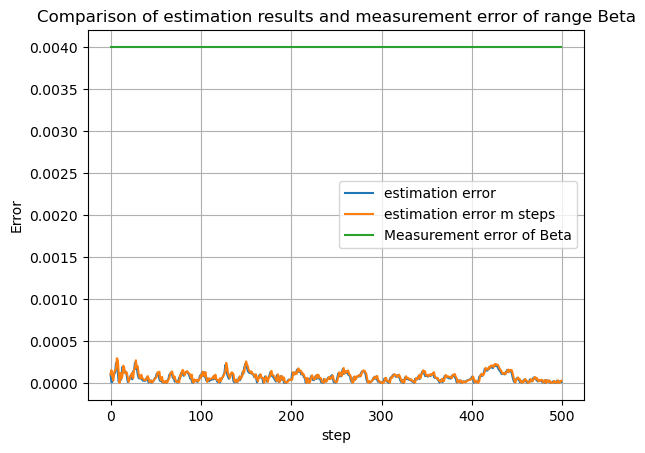

In [11]:
plt.plot(step, MSE1[0][1], label='estimation error')
plt.plot(step, MSE2[0][1], label='estimation error m steps')
plt.plot(step, sigmaB_v, label='Measurement error of Beta')
plt.title('Comparison of estimation results and measurement error of range Beta')
plt.xlabel('step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

Conclusion: Comparing the measurement errors to the eastimation error the measurement error of Beta is too high. 
Since we use the extendend Kalman filter of filteration the error is very low which close to zero.

## Conclusion

After using the extended kalman filter we found that it is really effective for tarcking a moving object when the measurements and motion model are in diferrent coordinate systems.Using the Extended kalman filter gives us Good understanding of how to deal with non-linear models for tracking moving objects. 

## Learning logs

We learned about filteration and prediction Using Extended kalman filter for tracking a moving object. Specifically we learnt how Extended kalman filter is effective for non-linear models.
